In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
sns.set_style("white")
sns.set_context("paper")
%load_ext rpy2.ipython
%matplotlib inline

/package/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/package/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/package/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/package/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/package/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [6]:
%%R

######################################################
### PERFORM DIFFERENTIAL ANALYSIS (NPC48h vs mESC) ###
######################################################

lib_ = "/home/ferrari/R/x86_64-redhat-linux-gnu-library/3.5"

library(DESeq2, lib = lib_)
library(rtracklayer, lib = lib_)

### IMPORT COUNTS ###
count=read.csv("../DATA/count_mESC-NPC48h.tsv", sep='\t', header = T, comment.char = '#')
rownames(count) = count$X
count$X = NULL
colnames(count) = c("mESC_DMSO_rep1","mESC_DMSO_rep2","mESC_DMSO_rep3",
                    "NPC48h_DMSO_2","NPC48h_DMSO_4","NPC48h_DMSO_5")


### CREATE DESIGN TABLE ###
design_table=data.frame(row.names = colnames(count),
                        condition = c(rep("mESC",3),rep("NPC48h",3)))

### CREATE DDS OBJECT ###
dds = DESeqDataSetFromMatrix(countData = count,
                              colData = design_table,
                              design = ~ condition)

### ADD FEATURE DATA ### 
anno18 <- import.gff2("../../COMMON_REPOSITORY/gencode.vM18.annotation.sorted.gtf", feature.type = "gene")

featureData = data.frame(row.names = anno18$gene_id,
                         gene_name = anno18$gene_name,
                         gene_type = anno18$gene_type,
                         level = anno18$level,
                         chr = seqnames(anno18))

index = match(row.names(dds),row.names(featureData))
mcols(dds) = DataFrame(mcols(dds), featureData[index,])

### PREFILTERING ###
keep = rowSums(counts(dds)) >= 10
dds = dds[keep,]

### SET REFERENCE LEVELS ###
dds$condition = relevel(dds$condition, ref = "mESC")

### CREATE RLOG TRANSFORMATION OF COUNT DATA ### 
rld = rlog(dds, blind=FALSE)
write.table(assay(rld), "../DATA/RLD_NPC48h_mESC.tsv", sep="\t", quote=F)


### DIFFERENTIAL EXPRESSION ANALYSIS ###
dds = DESeq(dds)

res = results(dds)
res_shrink = lfcShrink(dds, coef = "condition_NPC48h_vs_mESC", type="apeglm")
res_lfc_cutoff = results(dds, lfcThreshold=1, altHypothesis="greaterAbs")


res$symbol=mcols(dds)$gene_name
res_shrink$symbol=mcols(dds)$gene_name
res_lfc_cutoff$symbol=mcols(dds)$gene_name


### WRITE RESULTS TO FILE ###
resOrdered = as.data.frame(res[order(res$padj),])
write.table(resOrdered, 
            file = "../DATA/DE_genes_noLFCthr_mESCvsNPC48h.tsv", 
            quote = F, 
            sep = '\t')

resOrdered_shrink = as.data.frame(res_shrink[order(res_shrink$padj),])
write.table(resOrdered_shrink, 
            file = "../DATA/DE_genes_noLFCthr_shrinked_mESCvsNPC48h.tsv", 
            quote = F, 
            sep = '\t')

resOrdered_lfc = as.data.frame(res_lfc_cutoff[order(res_lfc_cutoff$padj),])
write.table(resOrdered_lfc, 
            file = "../DATA/DE_genes_withLFCthr1_mESCvsNPC48h.tsv", 
            quote = F, 
            sep = '\t')



/home/ferrari/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: estimating size factors

  warnings.warn(x, RRuntimeWarning)
/home/ferrari/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: estimating dispersions

  warnings.warn(x, RRuntimeWarning)
/home/ferrari/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: gene-wise dispersion estimates

  warnings.warn(x, RRuntimeWarning)
/home/ferrari/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: mean-dispersion relationship

  warnings.warn(x, RRuntimeWarning)
/home/ferrari/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: final dispersion estimates

  warnings.warn(x, RRuntimeWarning)
/home/ferrari/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: fitting model and testing

  warnings.warn(x, RRuntimeWarning)
/home/ferrari/.local/lib

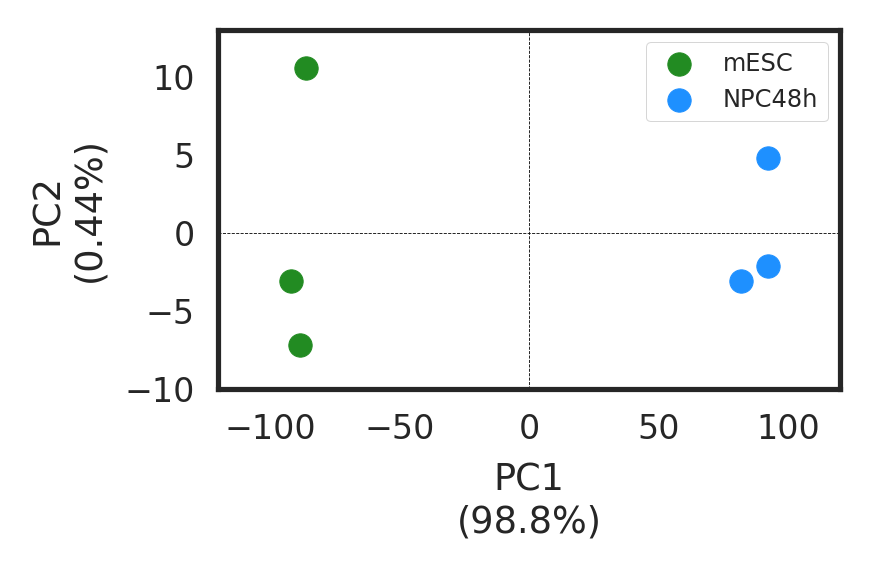

In [11]:
### IMPORT RLOG MATRIX ###
rlog = pd.read_csv("../DATA/RLD_NPC48h_mESC.tsv",sep="\t")
### select 500 most variable genes ###
top_var = rlog.var(axis=1).sort_values(ascending=False)[1:501].index
rlog = rlog.loc[top_var].T

### PERFORM PCA ###
pca = PCA()
pca_data = pca.fit_transform(rlog)

labels = ["PC{}".format(i) for i in range(pca_data.shape[1]+1)[1:]]
pca_df = pd.DataFrame(pca_data, index = ["mESC_1","mESC_2","mESC_3","NPC48h_1","NPC48h_2","NPC48h_3"], columns=labels)


### PLOT PCA ###
fig,ax=plt.subplots(dpi=300, figsize=(3,2))

plt.scatter(pca_df.filter(regex="^mESC", axis=0)["PC1"], pca_df.filter(regex="^mESC", axis=0)["PC2"], color="forestgreen", label = "mESC")
plt.scatter(pca_df.filter(regex="^NPC", axis=0)["PC1"], pca_df.filter(regex="^NPC", axis=0)["PC2"], color="dodgerblue", label = "NPC48h")

ax.set_xlabel("PC1\n({}%)".format(round(pca.explained_variance_ratio_[0]*100,2)))
ax.set_ylabel("PC2\n({}%)".format(round(pca.explained_variance_ratio_[1]*100,2)))

ax.set_ylim(-10,13)
ax.set_xlim(-120,120)

plt.axhline(0,linestyle="--",linewidth=0.2, color="k")
plt.axvline(0,linestyle="--",linewidth=0.2, color="k")

plt.legend(fontsize='xx-small', frameon=True)

plt.tight_layout()

plt.savefig("../FIGURES/PCA_mESC_NPC48h.pdf")